In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import ExtraTreesClassifier as ExTC
from pprint import pprint
from sklearn import metrics
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
R2 = pd.read_csv('./surrogate_performance/R^2.csv', index_col=0)
features = pd.read_csv('./features/benchmark.csv', index_col=0)

In [3]:
# Drop NANs
features.dropna(axis = 1, inplace=True)

In [4]:
# Drop columns with only one unique value
cols = features.select_dtypes([np.number]).columns
std = features[cols].std()
cols_to_drop = std[std==0].index
features = features.drop(cols_to_drop, axis=1)

In [5]:
# Drop columns with inf
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(axis = 1, inplace=True)

In [6]:
# Calculating Loss and Targets. Target is the modelling method with lowest loss.
loss = -R2.sub(R2.max(axis=1), axis=0)
targets = loss.idxmin(axis=1)

In [7]:
# Getting data that is avalable in both targets and features
features_available_for = targets.index.intersection(features.index)
targets = targets.loc[features_available_for]

In [8]:
# Train test split
train_features, test_features, train_targets, test_targets = tts(features, targets)

In [9]:
# Training the selector
selector = ExTC()
selector.fit(train_features.values, train_targets.values)

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [10]:
predicted_targets = selector.predict(test_features)
predicted_targets = pd.DataFrame(predicted_targets, index=test_features.index, columns=['Prediction'])

In [11]:
metrics.confusion_matrix(test_targets, predicted_targets)

array([[  1,   2,   1,   1,   1,   0,   0,   0,   0,   0,   5,   0,   0],
       [  1,   6,   0,   0,   0,   0,   0,   0,   0,   1,   2,   1,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2,   3,   6,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2,   9, 127,   3,   4,   1,   0,   1,   3,   0,   0],
       [  0,   0,   0,   0,   3, 137,   5,   0,   0,   0,   0,   3,   1],
       [  0,   0,   0,   0,   4,  12,  96,   4,   0,   0,   0,   0,   0],
       [  0,   0,   0,   1,   4,   0,  21,  56,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   3,   0],
       [  0,   0,   0,   1,   2,   0,   0,   0,   0,   1,   1,   0,   0],
       [  1,   3,   0,   2,   5,   0,   0,   0,   0,   0,  31,   2,   0],
       [  0,   0,   0,   2,   1,  18,   1,   0,   1,   0,   2,  65,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4]])

In [12]:
# For loss comparison
comparison_index = loss.index.intersection(predicted_targets.index)
loss_compare = loss.loc[comparison_index]
loss_prediction = pd.DataFrame(columns=['Prediction'], index=comparison_index, dtype=float)

In [13]:
for comp_id in comparison_index:
    loss_prediction['Prediction'].at[comp_id] = loss_compare[predicted_targets.loc[comp_id]].loc[comp_id]

In [14]:
loss_compare.sort_index(axis=1, inplace=True)
loss_compare = loss_compare.join(loss_prediction)

<IPython.core.display.Javascript object>


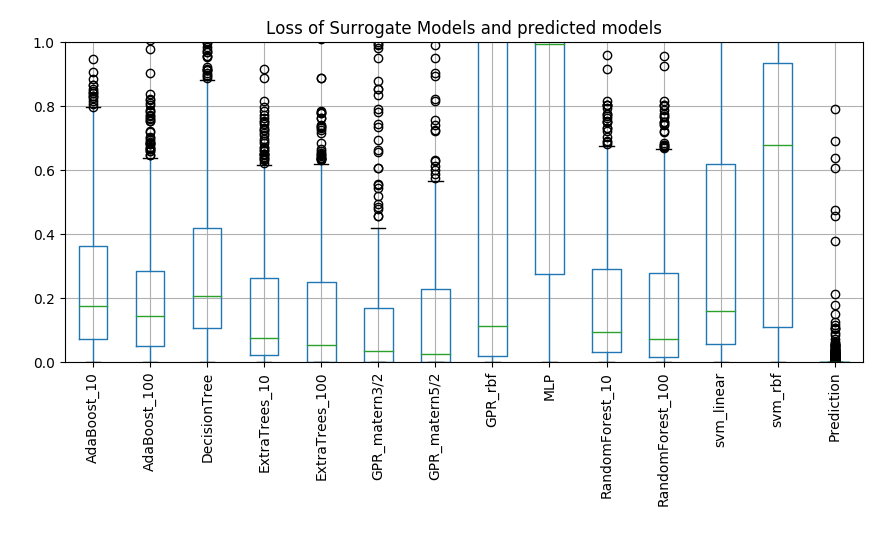

Prediction    0.035367
Name: 0.95, dtype: float64

In [15]:
loss_chart = loss_compare.boxplot(rot=90)
loss_chart.set_title('Loss of Surrogate Models and predicted models')
loss_chart.set_ylim([0,1])
plt.tight_layout()
loss_prediction.quantile(q=0.95)

In [16]:
loss_compare.describe()

,AdaBoost_10,AdaBoost_100,DecisionTree,ExtraTrees_10,ExtraTrees_100,GPR_matern3/2,GPR_matern5/2,GPR_rbf,MLP,RandomForest_10,RandomForest_100,svm_linear,svm_rbf,Prediction
count,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000
mean,0.271077,0.228475,0.313566,0.196782,0.179745,0.539361,1.040602,22.771249,3.499968,0.211305,0.195477,0.356385,0.611209,0.010972
std,0.291994,0.276555,0.308372,0.272424,0.274255,1.420953,5.169830,90.611807,5.350910,0.279930,0.281078,0.408769,0.523446,0.062305
min,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
25%,0.070554,0.049234,0.105267,0.023484,0.001122,0.000044,0.000553,0.019456,0.275964,0.031934,0.015626,0.056132,0.110632,-0.000000
50%,0.174832,0.142728,0.207952,0.074374,0.053567,0.034711,0.026406,0.112264,0.992673,0.093692,0.070745,0.160487,0.679716,-0.000000
75%,0.361524,0.286231,0.417750,0.262893,0.251194,0.168288,0.227135,2.527327,4.298559,0.291197,0.277036,0.618025,0.934459,-0.000000
max,1.713249,1.658380,1.639183,1.594604,1.595626,10.329465,107.708968,640.151586,26.627636,1.639989,1.622708,3.105061,2.657132,0.792031


## Feature Importances

In [17]:
importances = selector.feature_importances_
std = np.std([tree.feature_importances_ for tree in selector.estimators_],
             axis=0)
feat_importance = pd.DataFrame(np.vstack((importances, std)), columns=features.columns, index=['mean', 'std'])

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


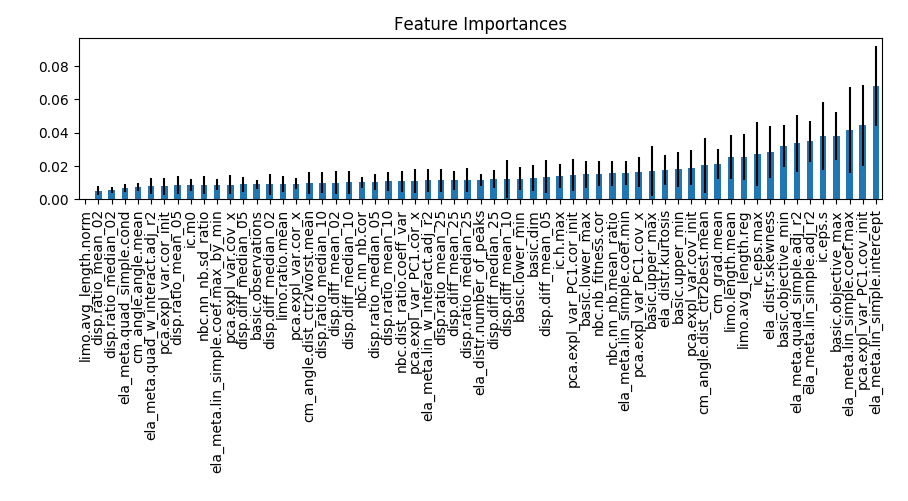

In [20]:
feat_importance.sort_index(by=['mean'], axis=1, inplace=True)
fig = feat_importance.loc['mean'].plot.bar(yerr=feat_importance.loc['std'])
plt.title('Feature Importances')
plt.tight_layout()

In [21]:
engineering_features = pd.read_csv("./features/engineering.csv", index_col=0)
engineering_features = engineering_features[features.columns]
engineering_features = engineering_features.dropna()

In [22]:
engineering_R2 = pd.read_csv('./surrogate_performance/engineeringR^2.csv', index_col=0)
# Calculating Loss and Targets. Target is the modelling method with lowest loss.
engineering_loss = -engineering_R2.sub(engineering_R2.max(axis=1), axis=0)
engineering_targets = engineering_loss.idxmin(axis=1)
# Getting data that is avalable in both targets and features
features_available_for = engineering_targets.index.intersection(engineering_features.index)
engineering_targets = engineering_targets.loc[features_available_for]
engineering_loss = engineering_loss.loc[features_available_for]

<IPython.core.display.Javascript object>


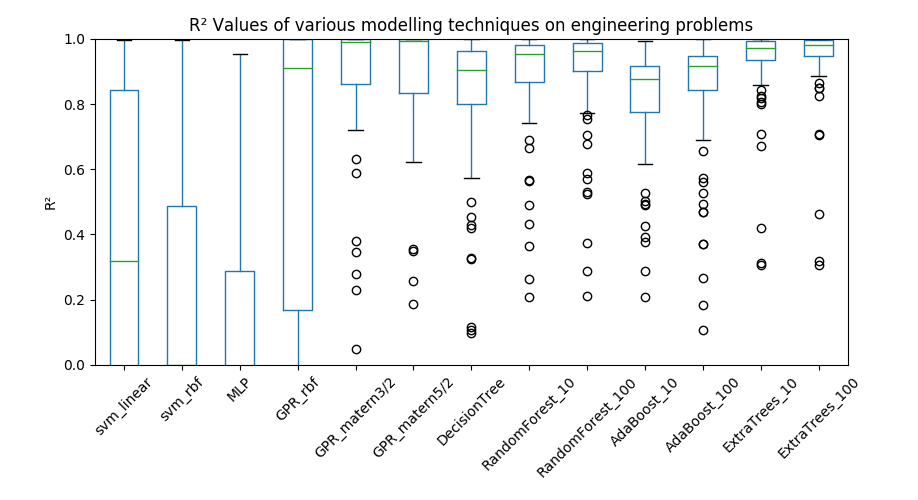

In [23]:
engineering_R2.plot.box(rot=45)
plt.ylim([0,1])
plt.ylabel('R²')
plt.title('R² Values of various modelling techniques on engineering problems')
plt.tight_layout()

In [24]:
selector = ExTC()
selector.fit(features.values, targets.values)
engineering_predictions = selector.predict(engineering_features)
engineering_predictions = pd.DataFrame(engineering_predictions, index=engineering_features.index, columns=['Prediction'])

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [25]:
metrics.confusion_matrix(engineering_targets, engineering_predictions)

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0],
       [ 1,  9,  4,  1,  0,  0,  0, 14],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3, 13,  1,  6,  0,  3],
       [ 1,  0,  9,  4,  0,  0,  0,  4],
       [ 0,  0,  0,  3,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [26]:
engineering_loss_prediction = pd.DataFrame(columns=['Prediction'], index=engineering_features.index, dtype=float)
for comp_id in engineering_features.index:
    engineering_loss_prediction['Prediction'].at[comp_id] = engineering_loss[engineering_predictions.loc[comp_id]].loc[comp_id]

In [27]:
engineering_loss.sort_index(axis=1, inplace=True)
engineering_loss = engineering_loss.join(engineering_loss_prediction)

<IPython.core.display.Javascript object>


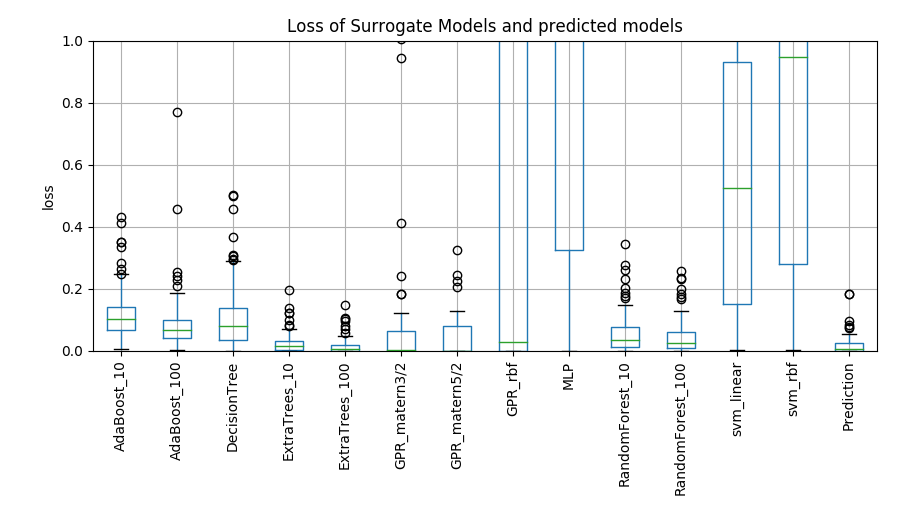

In [28]:
engg_loss_chart = engineering_loss.boxplot(rot=90)
engg_loss_chart.set_title('Loss of Surrogate Models and predicted models')
plt.ylabel('loss')
engg_loss_chart.set_ylim([0,1])
plt.tight_layout()
engg_loss_chart

<IPython.core.display.Javascript object>


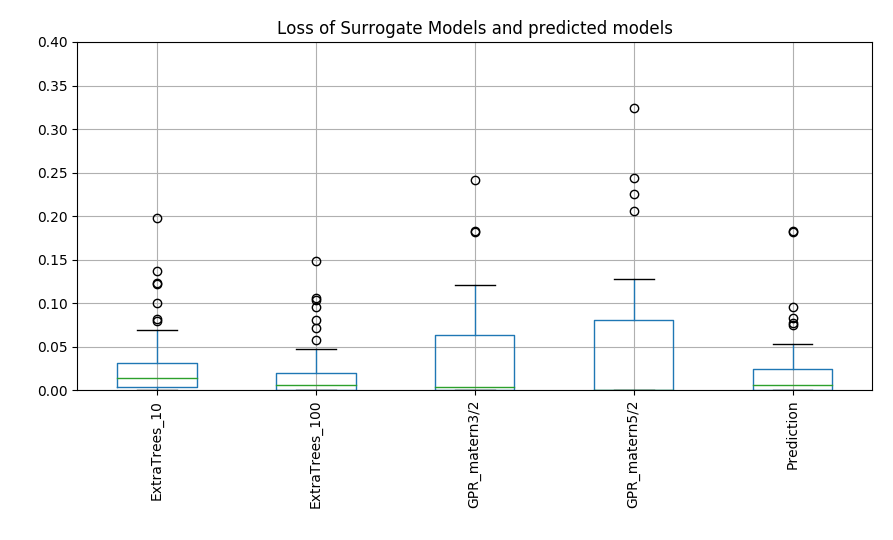

In [29]:
engg_loss_chart = engineering_loss[['ExtraTrees_10','ExtraTrees_100', 'GPR_matern3/2','GPR_matern5/2', 'Prediction']].boxplot(rot=90)
engg_loss_chart.set_title('Loss of Surrogate Models and predicted models')
engg_loss_chart.set_ylim([0,0.4])
plt.tight_layout()
engg_loss_chart

In [30]:
engineering_loss.describe()

,AdaBoost_10,AdaBoost_100,DecisionTree,ExtraTrees_10,ExtraTrees_100,GPR_matern3/2,GPR_matern5/2,GPR_rbf,MLP,RandomForest_10,RandomForest_100,svm_linear,svm_rbf,Prediction
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.119753,0.100426,0.111450,0.026402,0.016720,0.151598,0.176945,32.971680,66.272585,0.058712,0.048652,0.531101,0.703219,21.581987
std,0.095361,0.152892,0.116977,0.036064,0.028565,0.406823,0.490960,111.351412,220.510202,0.071614,0.060653,0.398577,0.436696,92.339830
min,0.005125,0.001085,0.000036,-0.000000,-0.000000,0.000002,-0.000000,-0.000000,-0.000000,0.000016,0.000010,0.002114,0.002207,-0.000000
25%,0.067919,0.039794,0.034042,0.003758,-0.000000,0.000107,-0.000000,0.000031,0.323454,0.013309,0.009045,0.149653,0.279390,0.000118
50%,0.101976,0.067813,0.079759,0.013654,0.005676,0.003260,0.000050,0.028301,3.723865,0.033138,0.024081,0.525263,0.948181,0.005676
75%,0.140208,0.099816,0.136860,0.030999,0.019397,0.063207,0.080757,1.547610,26.708943,0.074922,0.060918,0.932190,1.038348,0.023802
max,0.432549,1.053990,0.501111,0.197298,0.148233,2.214465,2.702947,413.478576,1259.316729,0.345750,0.256170,1.237660,1.306356,413.478562


In [31]:
engineering_loss.median()

AdaBoost_10         0.101976
AdaBoost_100        0.067813
DecisionTree        0.079759
ExtraTrees_10       0.013654
ExtraTrees_100      0.005676
GPR_matern3/2       0.003260
GPR_matern5/2       0.000050
GPR_rbf             0.028301
MLP                 3.723865
RandomForest_10     0.033138
RandomForest_100    0.024081
svm_linear          0.525263
svm_rbf             0.948181
Prediction          0.005676
dtype: float64